# Single queue simulation

This notebook provides a simple, single queue simulation. We generate jobs, run them through the system and compare the behavior to Little's Law for verification.

The goal is to develop intuitions about the underlying dynamics of the system, especially around inputs, outputs, and how queueing processes convert inputs into outputs. On the input side we want to understand how to reduce response times to queueing parameters. On the output side we want to understand the performance metrics available and how we can measure them.

**Reduction of response times to queueing parameters.** First we show how to reduce response times to the following queueing network parameters:

- mean arrival rate
- mean service rate

Eventually we will also incorporate

- job scheduling policy: policy around how we prioritize waiting jobs; and
- job assignment policy: policy around how we assign jobs to resources

though this notebook simply assumes First-Come-First-Served (FCFS) scheduling, and assumes a single resource (which makes assignment not applicable).

**Performance measurement.** We show how to measure the following performance metrics:

- response time
- number of jobs in the system
- wait time
- device utilization
- throughput

**Little's Law** for open systems is

$$ {\mathbb E}[N] = \lambda {\mathbb E}[T] $$

where

- $\lambda$ = mean job arrival rate
- $N$ = number of jobs in the system
- $T$ = response time (departure time minus arrival time)
- ${\mathbb E}$ is the expectation operator

## 0 Setup 

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from IPython.display import Markdown

In [2]:
TITLE_SIZE = 18

rng = np.random.default_rng(42)

## 1 Simulation 

In [3]:
# lambda = mean_arrival_rate
# mu = mean_service_rate
def run_sim_and_plot(n, mean_arrival_rate, mean_service_rate):
    params = build_params(n, mean_arrival_rate, mean_service_rate)
    display(Markdown(
        f"## Simulation: n={n}, " +
        f"$\lambda$={params['mean_arrival_rate']:,.4f}, " +
        f"$\mu$={params['mean_service_rate']:,.4f}, " +
        f"$1/\lambda$={params['mean_interarrival_time']:,.4f}, " +
        f"$1/\mu$={params['mean_service_time']:,.4f}"
    ))
    result = run_sim(params)
    dump_stats(result)
    plot_result(result)

def build_params(num_jobs, mean_arrival_rate, mean_service_rate):
    return {
        "n": num_jobs,
        "mean_arrival_rate": mean_arrival_rate,
        "mean_service_rate": mean_service_rate,
        "mean_interarrival_time": 1.0 / mean_arrival_rate,
        "mean_service_time": 1.0 / mean_service_rate,
        "num_bins": int(num_jobs / mean_arrival_rate)
    }
    
def run_sim(params):
    n = params["n"]
    
    # Parameters
    mean_interarrival_time = params["mean_interarrival_time"]
    mean_service_time = params["mean_service_time"]
    
    # Simulation data and results
    interarrival_times = rng.exponential(scale=mean_interarrival_time, size=n)
    arrival_times = np.cumsum(interarrival_times)
    service_times = rng.exponential(scale=mean_service_time, size=n)
    jobs_df = build_jobs_df(params, interarrival_times, arrival_times, service_times)
    intervals_df = build_intervals_df(params, jobs_df["arrive_time"], jobs_df["depart_time"])
    total_width = intervals_df.iloc[-1]["up_bd"]
    
    sim_mean_interarrival_time = jobs_df["interarrival_time"].mean()
    sim_mean_arrival_rate = 1.0 / sim_mean_interarrival_time
    sim_mean_service_time = jobs_df["service_time"].mean()
    sim_mean_service_rate = 1.0 / sim_mean_service_time
    sim_mean_wait_time = jobs_df["wait_time"].mean()
    sim_mean_response_time = jobs_df["response_time"].mean()
    
    # mean_num_jobs
    total_weighted_num_jobs = intervals_df["weighted_num_jobs"].sum()
    total_width = intervals_df.iloc[-1]["up_bd"]
    sim_mean_num_jobs = total_weighted_num_jobs / total_width
    
    # mean_throughput
    completions = intervals_df.loc[intervals_df["num_jobs_change"] == -1.0, "up_bd"]
    hist, _ = np.histogram(completions, bins=int(total_width))
    sim_mean_throughput = np.mean(hist)

    # utilization
    busy = intervals_df.loc[intervals_df["num_jobs"] > 0.0, "width"].sum()
    util = busy / total_width
    
    return {
        "params": params,
        "jobs_df": jobs_df,
        "intervals_df": intervals_df,
        "mean_arrival_rate": sim_mean_arrival_rate,
        "mean_interarrival_time": sim_mean_interarrival_time,
        "mean_service_rate": sim_mean_service_rate,
        "mean_service_time": sim_mean_service_time,
        "mean_wait_time": sim_mean_wait_time,
        "mean_response_time": sim_mean_response_time,
        "mean_num_jobs": sim_mean_num_jobs,
        "mean_throughput": sim_mean_throughput,
        "utilization": util,
    }

def build_jobs_df(params, interarrival_times, arrival_times, service_times):    
    n = params["n"]
    
    jobs_df = pd.DataFrame({
        "interarrival_time": interarrival_times,
        "arrive_time": arrival_times,
        "service_time": service_times,
        "start_time": np.zeros(n),
        "depart_time": np.zeros(n)
    })
    
    jobs_df.loc[0, "start_time"] = jobs_df.loc[0, "arrive_time"]
    jobs_df.loc[0, "depart_time"] = jobs_df.loc[0, "start_time"] + jobs_df.loc[0, "service_time"]
    
    for i in range(1, n):
        jobs_df.loc[i, "start_time"] = max(jobs_df.loc[i, "arrive_time"], jobs_df.loc[i-1, "depart_time"])
        jobs_df.loc[i, "depart_time"] = jobs_df.loc[i, "start_time"] + jobs_df.loc[i, "service_time"]
    
    jobs_df["response_time"] = jobs_df["depart_time"] - jobs_df["arrive_time"]
    jobs_df["wait_time"] = jobs_df["start_time"] - jobs_df["arrive_time"]
        
    return jobs_df

# Build intervals and their corresponding job counts so we can calculate E[N].
# We use two pointers: one for the arrival times and the other for the end (departure) times.
# At each iteration, the lower-valued pointer is the next interval's upper bound. We increment the job count
# whenever we choose the arrival time and we decrement the job count whenever we choose the end time.
def build_intervals_df(params, arrivals, departures):
    intervals_df = pd.DataFrame(columns=["lo_bd", "up_bd", "width", "num_jobs"])

    lo_bd = 0.0
    arrival_idx = 0
    end_idx = 0
    curr_num_jobs = 0
    n = params["n"]
    
    while arrival_idx < n and end_idx < n:
        curr_num_jobs_orig = curr_num_jobs
        curr_arrival = arrivals[arrival_idx]
        curr_end = departures[end_idx]
        if curr_arrival < curr_end:
            curr_num_jobs = curr_num_jobs + 1
            up_bd = curr_arrival
            arrival_idx = arrival_idx + 1
        else:
            curr_num_jobs = curr_num_jobs - 1
            up_bd = curr_end
            end_idx = end_idx + 1

        width = up_bd - lo_bd
        intervals_df = intervals_df.append({
            "lo_bd": lo_bd,
            "up_bd": up_bd,
            "width": width,
            "num_jobs": curr_num_jobs,
            "num_jobs_change": curr_num_jobs - curr_num_jobs_orig,
            "weighted_num_jobs": width * curr_num_jobs
        }, ignore_index=True)

        lo_bd = up_bd
    
    return intervals_df

In [4]:
# STATS DUMPS

def dump_stats(result):
    params = result["params"]
    jobs_df = result["jobs_df"]
    intervals_df = result["intervals_df"]
    mean_arrival_rate = result["mean_arrival_rate"]
    mean_response_time = result["mean_response_time"]
    
    print("Simulation statistics")
    print("---------------------")
    print(f"mean_arrival_rate      = {mean_arrival_rate:,.4f}")
    print(f"mean_interarrival_time = {result['mean_interarrival_time']:,.4f}")
    # Note: E[response_time] = E[wait_time] + E[service_time]
    print(f"mean_response_time     = {mean_response_time:,.4f}")
    print(f"mean_wait_time         = {result['mean_wait_time']:,.4f}")
    print(f"mean_service_time      = {result['mean_service_time']:,.4f}")
    print(f"mean_num_jobs          = {result['mean_num_jobs']:,.4f}")
    print(f"mean_throughput        = {result['mean_throughput']:,.4f}")
    print(f"utilization            = {result['utilization']:,.4f}")
    print("")
    print("Little's Law: E[N] = lambda * E[T]")
    print("----------------------------------")
    print(f"mean_num_jobs                          = {result['mean_num_jobs']:,.4f}")
    print(f"mean_arrival_rate * mean_response_time = {mean_arrival_rate * mean_response_time:,.4f}" +
         f" (= {mean_arrival_rate:,.4f} * {mean_response_time:,.4f})")

In [5]:
# PLOTTING FUNCTIONS

def plot_result(result):
    params = result["params"]
    jobs_df = result["jobs_df"]
    intervals_df = result["intervals_df"]
    
    _plot_interarrival_times(params, jobs_df["interarrival_time"])
    _plot_arrival_times(params, jobs_df["arrive_time"])
    _plot_service_times(params, jobs_df["service_time"])
    _plot_jobs_gantt(params, jobs_df)    
    _plot_jobs_over_time(intervals_df)    

def _plot_interarrival_times(params, interarrival_times):
    plt.figure(figsize=(14, 4))
    plt.title("Histogram of interarrival times", size=TITLE_SIZE)
    plt.xlabel("Interarrival time")
    plt.ylabel("Count")
    plt.hist(interarrival_times, bins=params["num_bins"])
    plt.show()

def _plot_arrival_times(params, arrival_times):
    plt.figure(figsize=(14, 4))
    plt.title("Histogram of arrival times", size=TITLE_SIZE)
    plt.xlabel("Arrival time")
    plt.ylabel("Count")
    plt.hist(arrival_times, bins=params["num_bins"])
    plt.show()

def _plot_service_times(params, service_times):
    plt.figure(figsize=(14, 4))
    plt.title("Histogram of service times", size=TITLE_SIZE)
    plt.xlabel("Service time")
    plt.ylabel("Count")
    plt.hist(service_times, bins=params["num_bins"])
    plt.show()

def _plot_jobs_gantt(params, jobs_df):
    n = params["n"]
    start_job = int(n / 2)
    end_job = start_job + 40
    trunc_df = jobs_df[start_job:end_job]
    
    plt.figure(figsize=(14, 8))
    plt.title("Job schedule", size=TITLE_SIZE)
    plt.barh(
        y=trunc_df.index,
        left=trunc_df["arrive_time"],
        width=trunc_df["response_time"],
        alpha=1.0,
        color="gainsboro")
    plt.barh(
        y=trunc_df.index,
        left=trunc_df["start_time"],
        width=trunc_df["service_time"],
        alpha=1.0,
        color="limegreen")
    plt.gca().invert_yaxis()
    plt.grid(axis="x")
    plt.show()

def _plot_jobs_over_time(intervals_df):
    plt.figure(figsize=(14, 4))
    plt.title("Job count over time", size=TITLE_SIZE)
    plt.xlabel("Time")
    plt.ylabel("Job count")
    plt.plot(intervals_df["lo_bd"], intervals_df["num_jobs"])
    plt.show()

## Simulation: n=4000, $\lambda$=16.0000, $\mu$=64.0000, $1/\lambda$=0.0625, $1/\mu$=0.0156

Simulation statistics
---------------------
mean_arrival_rate      = 15.9990
mean_interarrival_time = 0.0625
mean_response_time     = 0.0200
mean_wait_time         = 0.0049
mean_service_time      = 0.0151
mean_num_jobs          = 0.9259
mean_throughput        = 15.9960
utilization            = 0.8500

Little's Law: E[N] = lambda * E[T]
----------------------------------
mean_num_jobs                          = 0.9259
mean_arrival_rate * mean_response_time = 0.3204 (= 15.9990 * 0.0200)


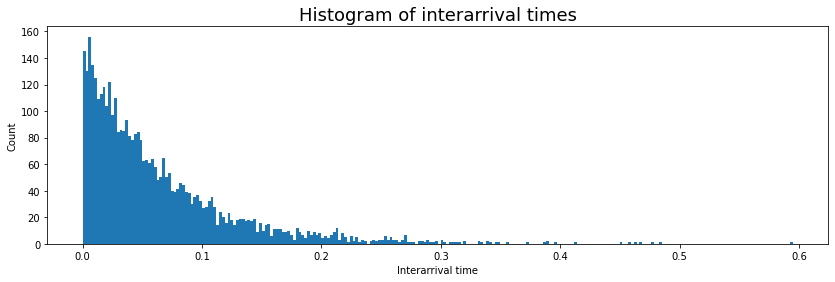

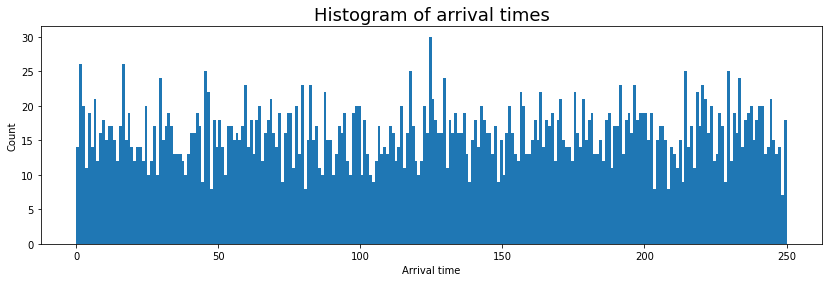

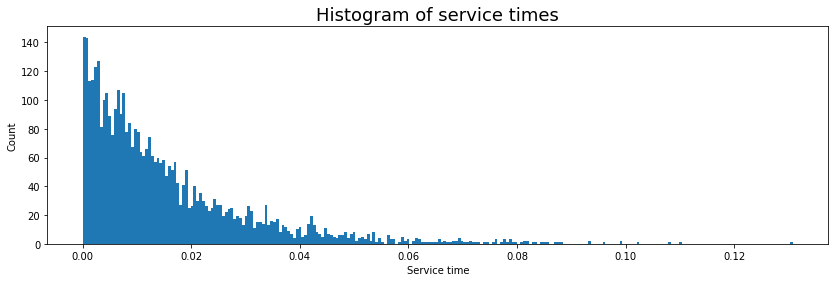

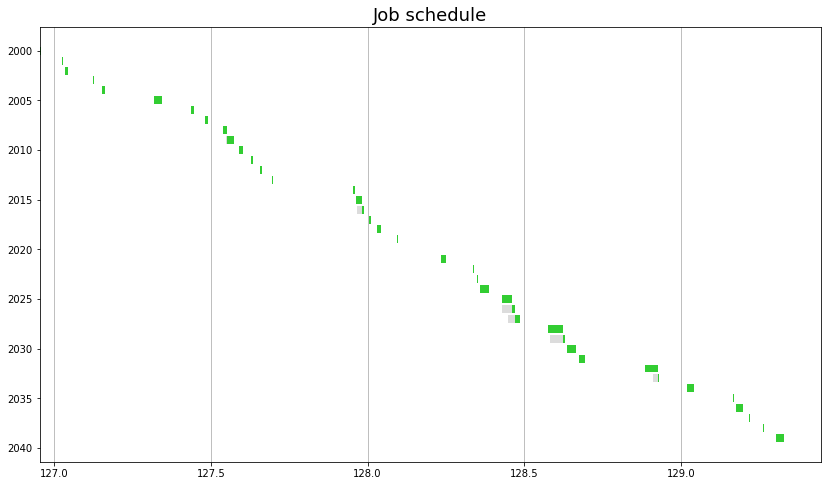

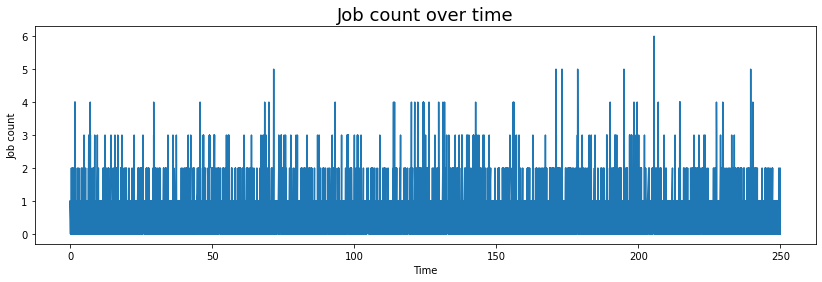

## Simulation: n=4000, $\lambda$=16.0000, $\mu$=32.0000, $1/\lambda$=0.0625, $1/\mu$=0.0312

Simulation statistics
---------------------
mean_arrival_rate      = 15.7136
mean_interarrival_time = 0.0636
mean_response_time     = 0.0646
mean_wait_time         = 0.0331
mean_service_time      = 0.0315
mean_num_jobs          = 1.3493
mean_throughput        = 15.7402
utilization            = 0.8308

Little's Law: E[N] = lambda * E[T]
----------------------------------
mean_num_jobs                          = 1.3493
mean_arrival_rate * mean_response_time = 1.0155 (= 15.7136 * 0.0646)


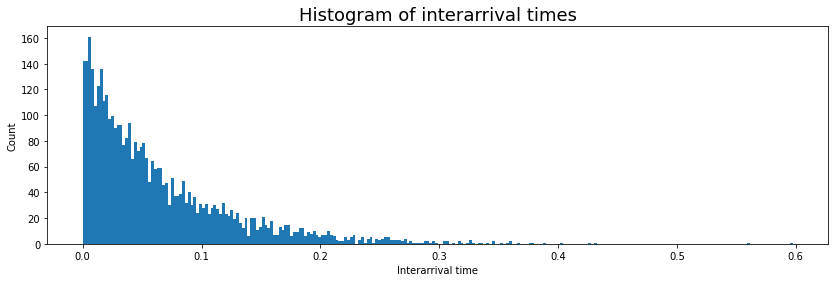

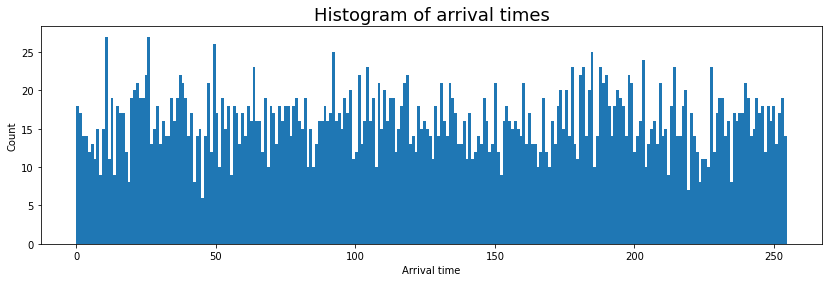

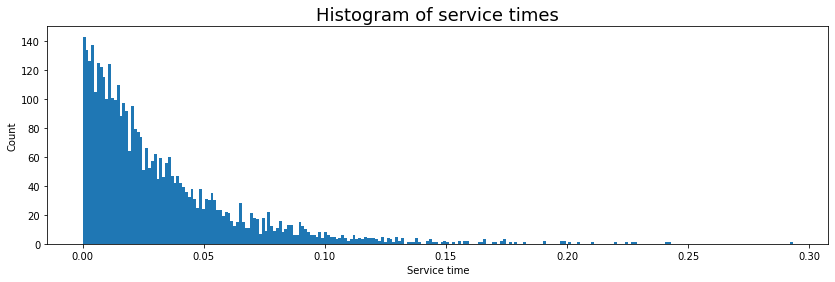

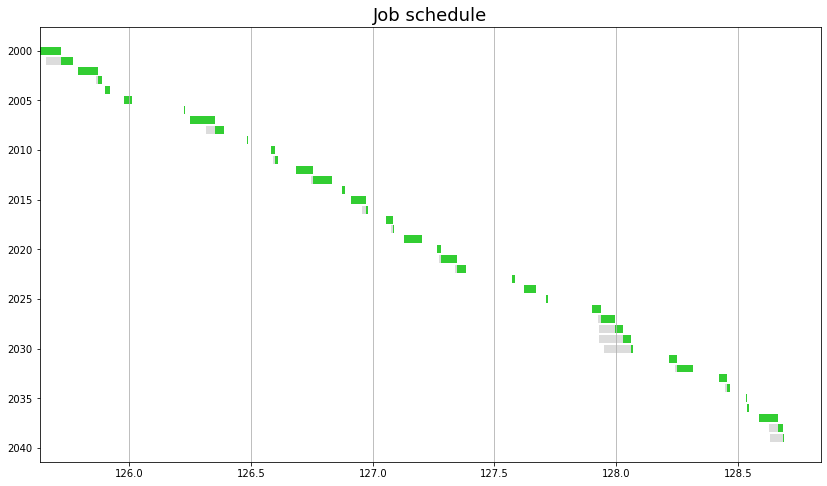

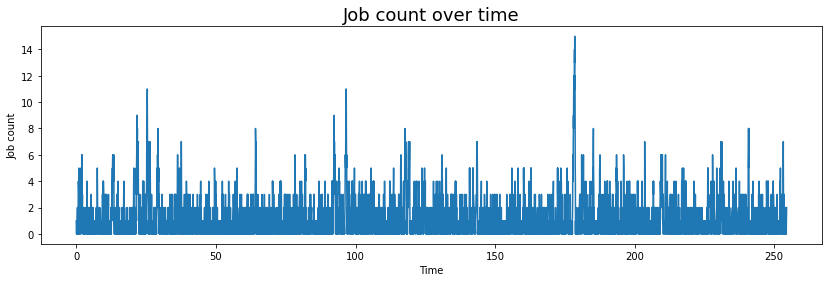

## Simulation: n=4000, $\lambda$=16.0000, $\mu$=18.0000, $1/\lambda$=0.0625, $1/\mu$=0.0556

Simulation statistics
---------------------
mean_arrival_rate      = 16.1498
mean_interarrival_time = 0.0619
mean_response_time     = 0.4744
mean_wait_time         = 0.4187
mean_service_time      = 0.0557
mean_num_jobs          = 7.7131
mean_throughput        = 16.1822
utilization            = 0.9548

Little's Law: E[N] = lambda * E[T]
----------------------------------
mean_num_jobs                          = 7.7131
mean_arrival_rate * mean_response_time = 7.6621 (= 16.1498 * 0.4744)


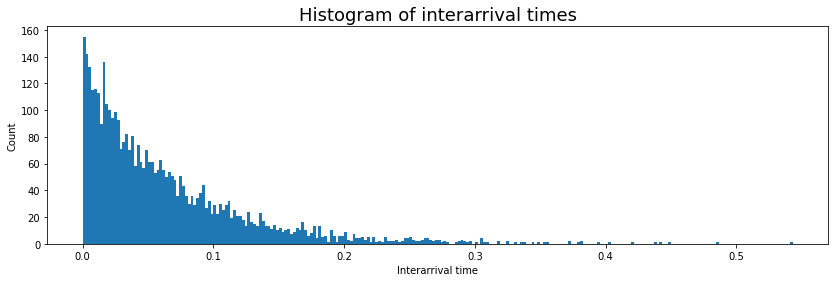

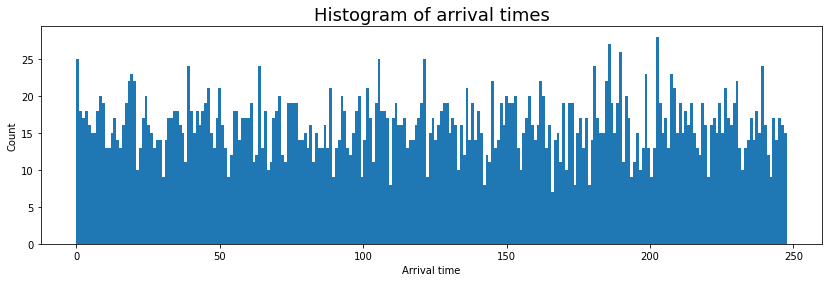

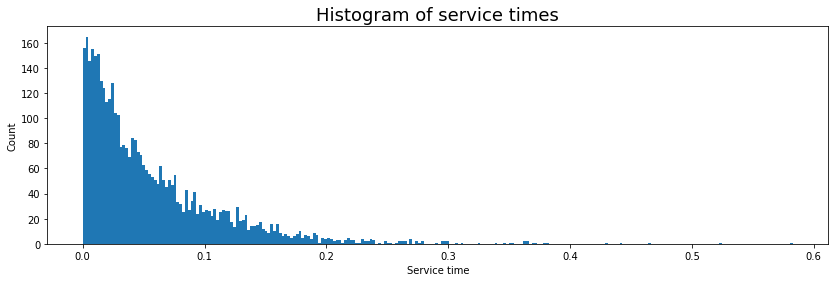

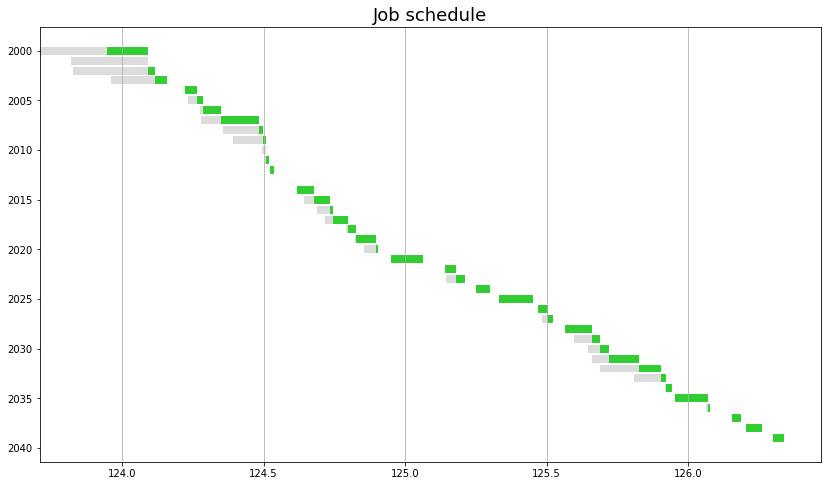

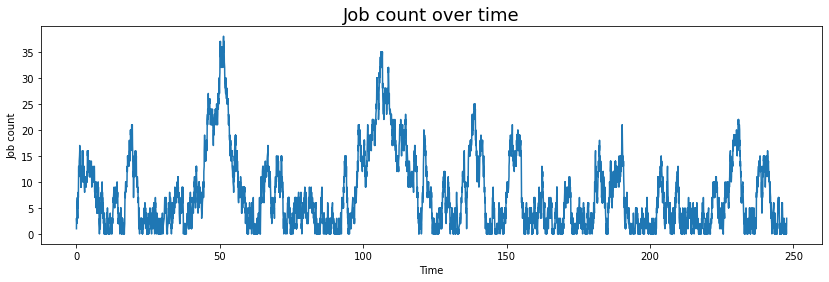

## Simulation: n=4000, $\lambda$=16.0000, $\mu$=16.0000, $1/\lambda$=0.0625, $1/\mu$=0.0625

Simulation statistics
---------------------
mean_arrival_rate      = 16.0617
mean_interarrival_time = 0.0623
mean_response_time     = 4.1179
mean_wait_time         = 4.0539
mean_service_time      = 0.0640
mean_num_jobs          = 64.7097
mean_throughput        = 15.6386
utilization            = 1.0000

Little's Law: E[N] = lambda * E[T]
----------------------------------
mean_num_jobs                          = 64.7097
mean_arrival_rate * mean_response_time = 66.1412 (= 16.0617 * 4.1179)


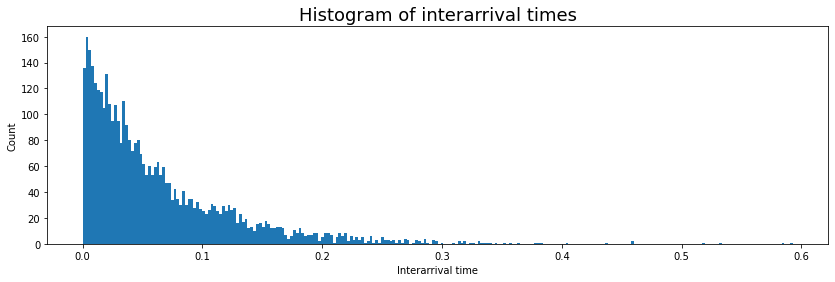

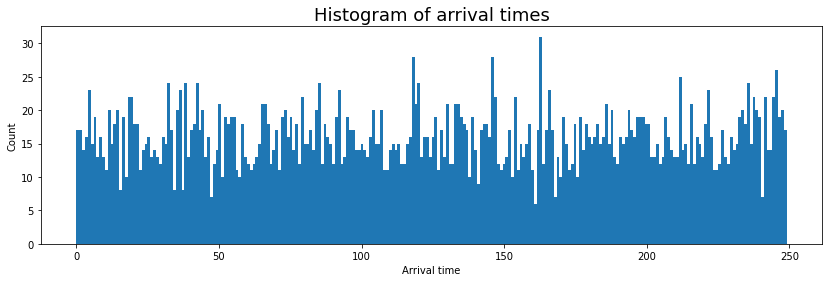

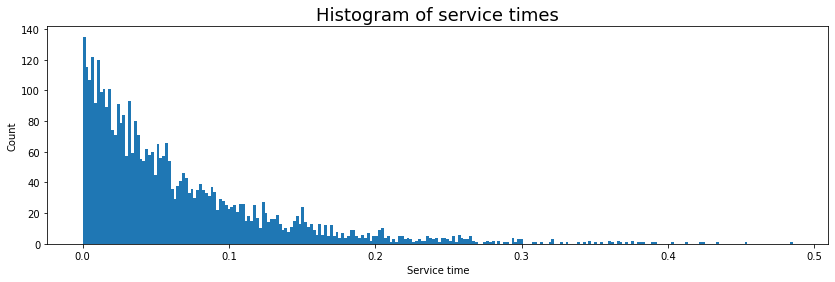

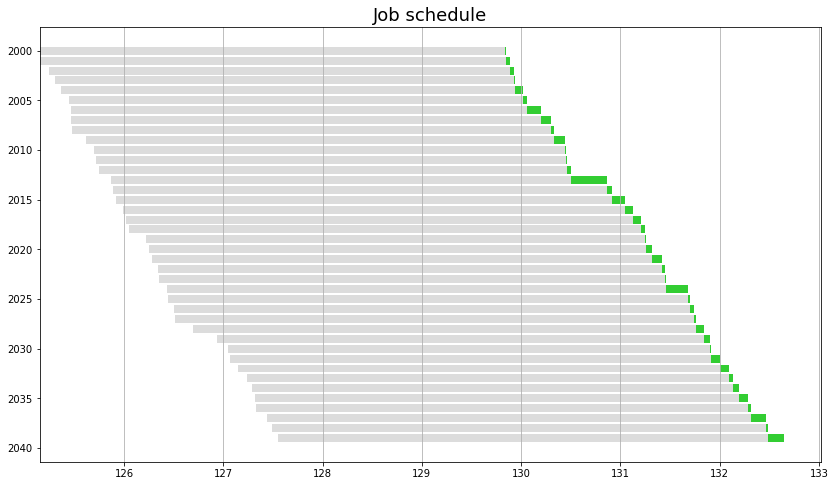

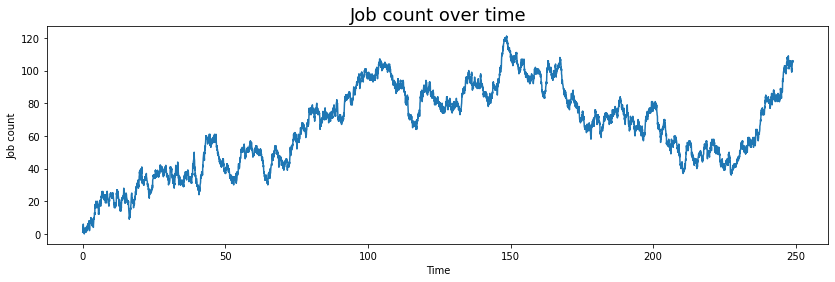

## Simulation: n=4000, $\lambda$=16.0000, $\mu$=15.0000, $1/\lambda$=0.0625, $1/\mu$=0.0667

Simulation statistics
---------------------
mean_arrival_rate      = 16.0300
mean_interarrival_time = 0.0624
mean_response_time     = 11.9850
mean_wait_time         = 11.9178
mean_service_time      = 0.0672
mean_num_jobs          = 178.5873
mean_throughput        = 14.6546
utilization            = 0.9986

Little's Law: E[N] = lambda * E[T]
----------------------------------
mean_num_jobs                          = 178.5873
mean_arrival_rate * mean_response_time = 192.1188 (= 16.0300 * 11.9850)


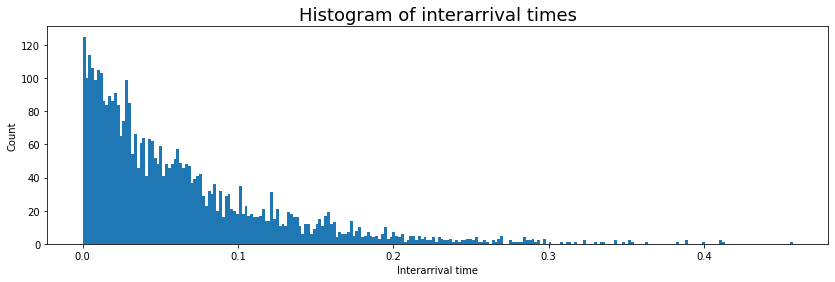

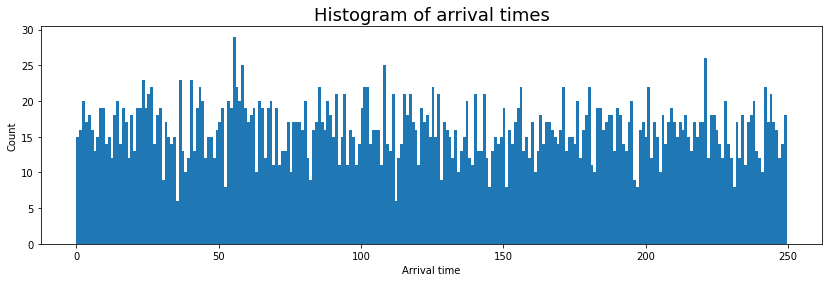

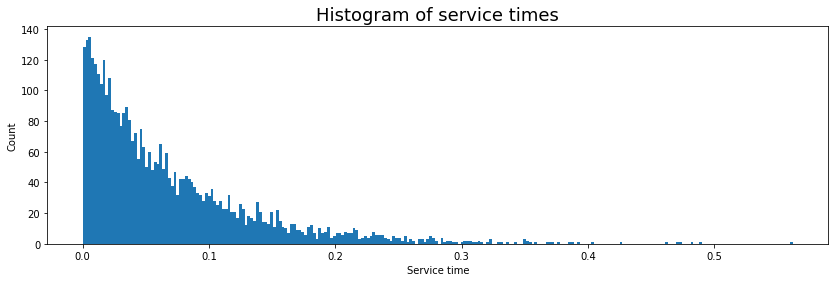

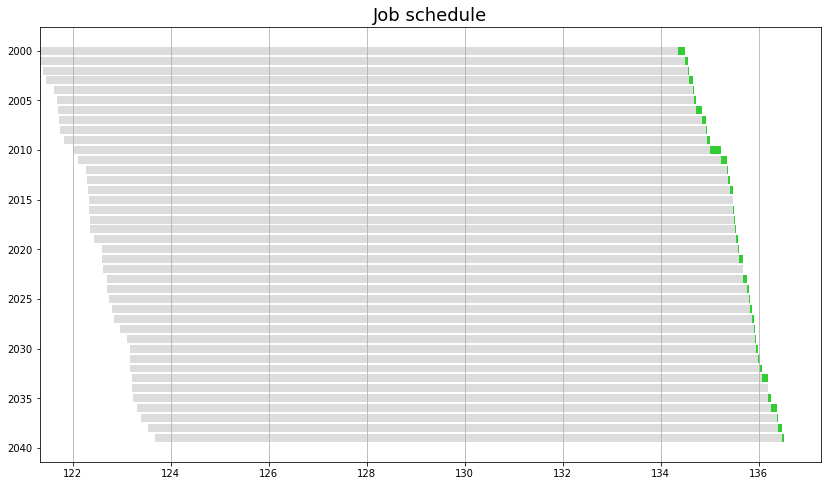

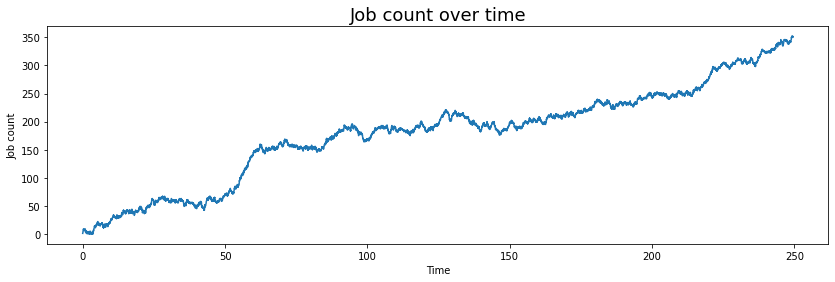

## Simulation: n=4000, $\lambda$=16.0000, $\mu$=12.0000, $1/\lambda$=0.0625, $1/\mu$=0.0833

Simulation statistics
---------------------
mean_arrival_rate      = 15.9335
mean_interarrival_time = 0.0628
mean_response_time     = 40.4630
mean_wait_time         = 40.3801
mean_service_time      = 0.0828
mean_num_jobs          = 483.5909
mean_throughput        = 12.0837
utilization            = 0.9967

Little's Law: E[N] = lambda * E[T]
----------------------------------
mean_num_jobs                          = 483.5909
mean_arrival_rate * mean_response_time = 644.7175 (= 15.9335 * 40.4630)


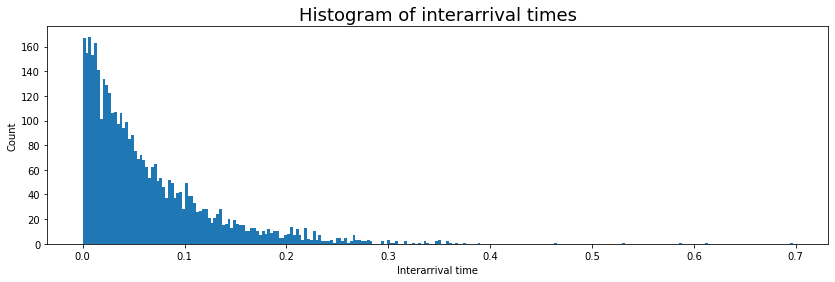

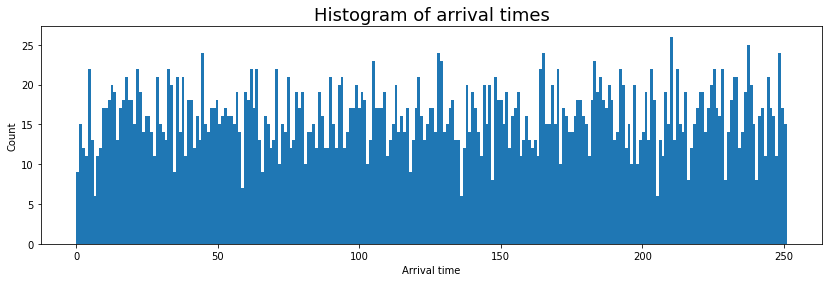

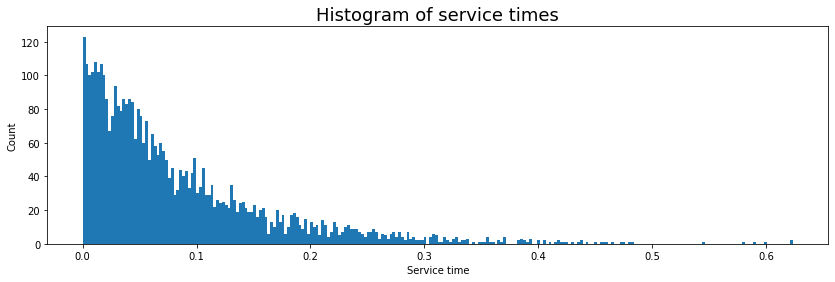

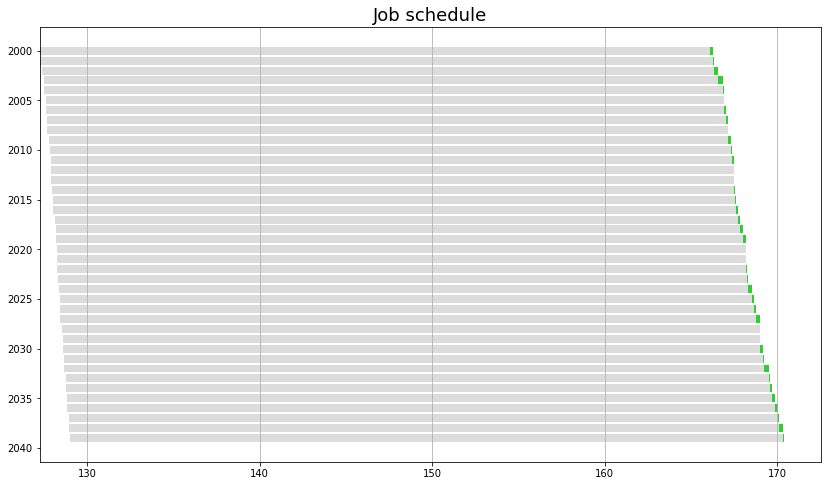

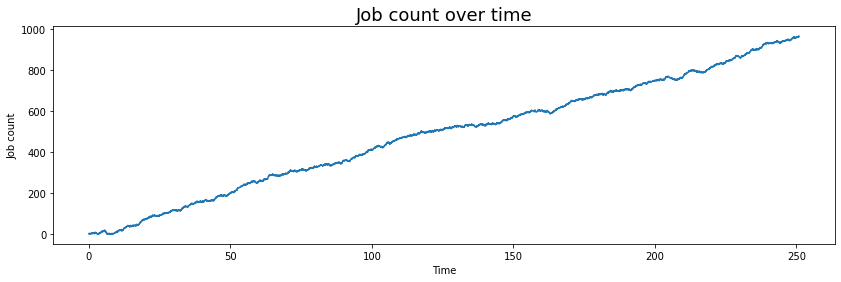

In [6]:
for mu in [64, 32, 18, 16, 15, 12]:
    run_sim_and_plot(4000, 16, mu)